# Notebook to make TS diagrams for the control volume outlined in 'overview_figure.ipynb'
The analysis goal here is to see if the TXLA model and observations are similar. Not intended to be a skill assesment, just checking to see if the calculations are in the same universe. 

In [2]:
#Packages
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-92.5)
import time 
import gsw as gsw
import pandas as pd

In [3]:
paths = glob.glob('/d1/shared/TXLA_ROMS/nesting/2022/nest/ocean_his_child_*.nc')
ds = xroms.open_mfnetcdf(paths, chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, Vtransform = 2)

In [4]:
# Box for the location of the cruise
lon = np.array([-92.6,-92])
lat = np.array([28.8,29.2])
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

In [6]:
tslice = slice('2022-07-03','2022-07-05 2:00')
temp = ds.temp.where(box).sel(ocean_time=tslice).load()
salt = ds.salt.where(box).sel(ocean_time=tslice).load()
# density = xroms.potential_density(temp,salt,z=0)
# rho = density.sel(ocean_time=tslice).load()

# start = time.process_time()
# tempstack = temp.stack(z=['xi_rho','eta_rho', 'ocean_time','s_rho']).values  
# print(time.process_time() - start)
# saltstack = salt.stack(z=['xi_rho','eta_rho', 'ocean_time','s_rho']).values
# print(time.process_time() - start)
# denstack = density.stack(z=['xi_rho','eta_rho', 'ocean_time','s_rho']).values
# print(time.process_time() - start)

# print(np.shape(denstack))

In [7]:
print(temp.max().values)
print(temp.min().values)
print(salt.max().values)
print(salt.min().values)
# print(density.max().values)
# print(density.min().values)

40.07931900024414
25.12924575805664
35.773902893066406
22.118309020996094


[-92.6, -92, 28.8,29.2]

In [8]:
tempbins = np.linspace(25,40.1,201)
saltbins = np.linspace(22,36,201)

tshist = histogram(salt,temp,bins=[saltbins,tempbins],dim=['xi_rho','eta_rho','ocean_time','s_rho'],block_size=salt.ocean_time.size, density=True).compute()
# ts_denhist = histogram(salt,temp,bins=[saltbins,tempbins],weights=density,dim=['xi_rho','eta_rho','ocean_time','s_rho'], block_size=salt.ocean_time.size).compute()

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


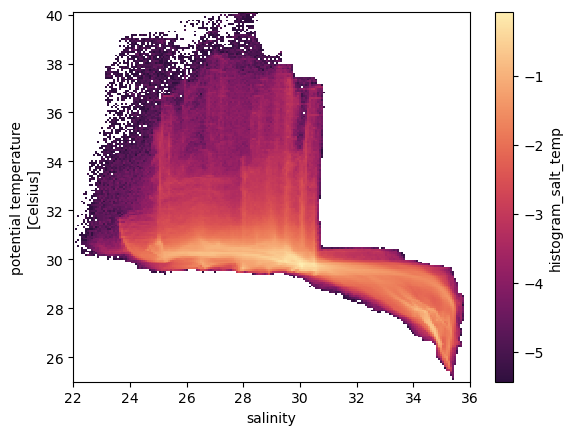

In [9]:
np.log10(tshist.T).plot(cmap = cmo.matter_r)
# plt.contour(salt[0],temp[0],density[0], levels = 10, colors = 'k', vmin = 0, vmax = 3)
# plt.xlim()

# We should be able to plot the contours on here, but it will likely require manipulation

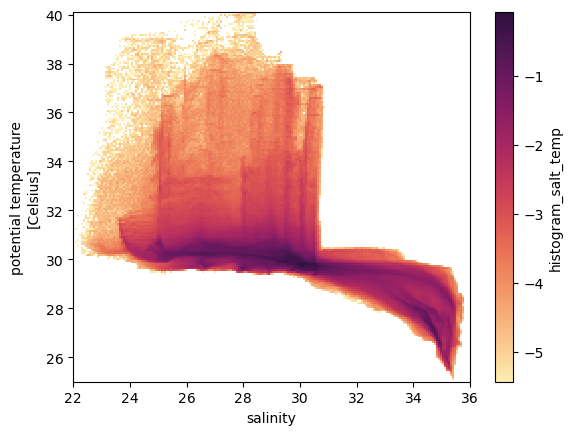

In [10]:
np.log10(tshist.T).plot(cmap = cmo.matter)
# plt.contour(salt[0],temp[0],density[0], levels = 10, colors = 'k', vmin = 0, vmax = 3)
# plt.xlim()

In [11]:
si = np.load('salt_lines_ts.npy')
ti = np.load('temp_lines_ts.npy')
dens = np.load('density_lines_ts.npy')

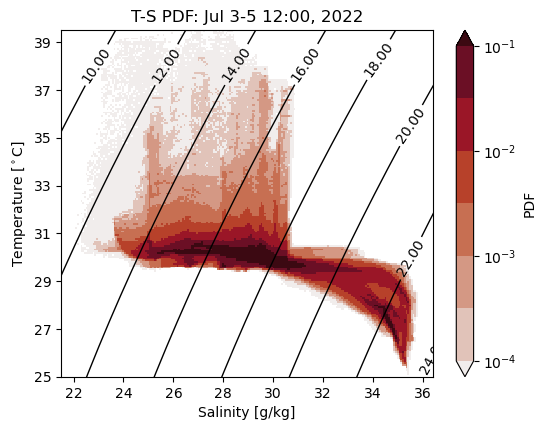

In [12]:
fig, ax = plt.subplots(1, figsize = (6,4.5))
m = np.log10(tshist.T).plot(cmap = cmo.amp, vmin = -4, vmax = -1, levels = 7, add_colorbar = False)
# plt.contour(saltstack[::10],tempstack[::10],denstack[::10], levels = 10, colors = 'k', vmin = 0, vmax = 3, lw = 1)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = plt.contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'Temperature [$^\circ$C]')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax, label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

plt.title('T-S PDF: Jul 3-5 12:00, 2022')
plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

Text(0.5, 1.0, 'T-S Surface PDF: Jul 3-5 12:00, 2022')

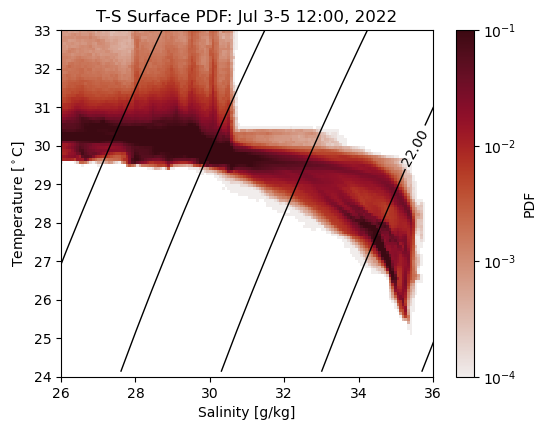

In [13]:
fig, ax = plt.subplots(1, figsize = (6,4.5))
m = np.log10(tshist.T).plot(cmap = cmo.amp, vmin = -4, vmax = -1, add_colorbar = False)
# plt.contour(saltstack[::10],tempstack[::10],denstack[::10], levels = 10, colors = 'k', vmin = 0, vmax = 3, lw = 1)
plt.xlim(26,36)
plt.ylim(24,33)

CS = plt.contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'Temperature [$^\circ$C]')
plt.xlabel('Salinity [g/kg]')
# plt.yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax, label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

plt.title('T-S Surface PDF: Jul 3-5 12:00, 2022')

# Open the observational cruise data. 
Processes the .mat file as is. Looking for SA,SP and temp are what we're looking for 

In [111]:
import mat73
da = mat73.loadmat('SUNRISE2022_PE_HydroCombo_Processed.mat')
da

{'DO2A': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'DO2R': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'Fl': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'SA': array([[24.59723385, 24.5511014 , 24.37186426, ..., 27.61868573,
         27.60693571, 27.60192383],
        [25.382

# Datetimes need a small amount of processesing as they're left in Matlab time.  
Looks like the 'dn' variable is what we're after, or datenumber 

In [112]:
import pandas as pd
datenums = da['dn']
time = pd.to_datetime(datenums-719529, unit='D') # Stack exchange saving me again 
time

DatetimeIndex(['2022-06-18 03:09:18.729457920',
               '2022-06-18 03:11:11.409755904',
               '2022-06-18 03:12:35.919969536',
               '2022-06-18 03:14:04.867404800',
               '2022-06-18 03:15:45.657835776',
               '2022-06-18 03:24:59.030855424',
               '2022-06-18 03:26:59.293671168',
               '2022-06-18 03:28:49.180391424',
               '2022-06-18 03:30:34.300984064',
               '2022-06-19 06:43:18.101357312',
               ...
               '2022-07-05 09:04:04.420068352',
               '2022-07-05 09:05:17.868493056',
               '2022-07-05 09:06:31.504414464',
               '2022-07-05 09:07:45.077833472',
               '2022-07-05 09:08:58.526258176',
               '2022-07-05 09:10:08.896757760',
               '2022-07-05 09:11:20.235940096',
               '2022-07-05 09:12:26.137976576',
               '2022-07-05 09:13:37.367795456',
               '2022-07-05 09:14:50.066274560'],
              dtype=

In [113]:
time[9490:11500]

DatetimeIndex(['2022-07-02 17:56:49.578492160',
               '2022-07-02 17:58:29.589154560',
               '2022-07-02 18:00:08.943504128',
               '2022-07-02 18:01:49.594859264',
               '2022-07-02 18:03:30.918168064',
               '2022-07-02 18:05:12.991553280',
               '2022-07-02 18:06:53.236613888',
               '2022-07-02 18:08:35.419383040',
               '2022-07-02 18:10:17.695915264',
               '2022-07-02 18:12:00.472505344',
               ...
               '2022-07-05 01:52:37.035075584',
               '2022-07-05 01:53:54.887127552',
               '2022-07-05 01:55:11.879719424',
               '2022-07-05 01:56:28.700405248',
               '2022-07-05 01:57:45.739868672',
               '2022-07-05 01:59:03.748196096',
               '2022-07-05 02:00:25.678801920',
               '2022-07-05 02:01:46.109254912',
               '2022-07-05 02:03:06.149043968',
               '2022-07-05 02:04:29.204769280'],
              dtype=

# Great, good to go. 
Look at the absolute salinity 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'T-S PDF: Jul 3-5 12:00, 2022')

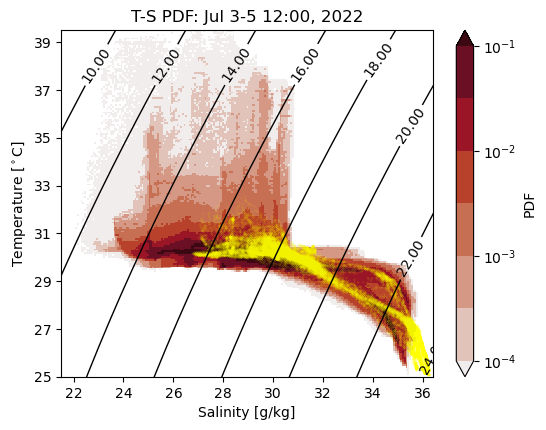

In [114]:
fig, ax = plt.subplots(1, figsize = (6,4.5))
m = np.log10(tshist.T).plot(cmap = cmo.amp, vmin = -4, vmax = -1, levels = 7, add_colorbar = False)
# plt.contour(saltstack[::10],tempstack[::10],denstack[::10], levels = 10, colors = 'k', vmin = 0, vmax = 3, lw = 1)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = plt.contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'Temperature [$^\circ$C]')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax, label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))


plt.scatter(da['SA'][:,9490:11500],da['theta'][:,9490:11500],s=0.05, c = 'yellow', alpha = 0.25)

plt.title('T-S PDF: Jul 3-5 12:00, 2022')
# plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

# Clean up code for plotting. Cribbed some code from stack exchange to help recovering dictionaries from the .mat file 

In [115]:
from scipy.io import loadmat, matlab
def load_mat(filename):
    """
    This function should be called instead of direct scipy.io.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """

    def _check_vars(d):
        """
        Checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in d:
            if isinstance(d[key], matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _toarray(d[key])
        return d

    def _todict(matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _toarray(elem)
            else:
                d[strg] = elem
        return d

    def _toarray(ndarray):
        """
        A recursive function which constructs ndarray from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        if ndarray.dtype != 'float64':
            elem_list = []
            for sub_elem in ndarray:
                if isinstance(sub_elem, matlab.mio5_params.mat_struct):
                    elem_list.append(_todict(sub_elem))
                elif isinstance(sub_elem, np.ndarray):
                    elem_list.append(_toarray(sub_elem))
                else:
                    elem_list.append(sub_elem)
            return np.array(elem_list)
        else:
            return ndarray

    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_vars(data)

data = load_mat('vmp_alldata_PE_PS.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu May 18 08:58:49 2023',
 '__version__': '1.0',
 '__globals__': [],
 'vmp_bin': {'DO2A': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'DO2R': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]),
  'Fl': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
 

In [116]:
dn = data['vmp_bin']['dn']
dn1 = data['vmp_binSP']['dn']

#Check the times manually by hand 
time = pd.to_datetime(dn-719529, unit='D') # Stack exchange saving me again 
time1 = pd.to_datetime(dn1-719529, unit='D') # Stack exchange saving me again 

In [117]:
time[9685:11500]

DatetimeIndex(['2022-07-03 00:00:25.028651264',
               '2022-07-03 00:02:06.430092800',
               '2022-07-03 00:03:53.425871360',
               '2022-07-03 00:05:35.889930240',
               '2022-07-03 00:07:19.463468288',
               '2022-07-03 00:08:20.264003584',
               '2022-07-03 00:09:02.927632384',
               '2022-07-03 00:09:44.319844096',
               '2022-07-03 00:11:29.815469824',
               '2022-07-03 00:13:13.342136320',
               ...
               '2022-07-05 01:52:37.035075584',
               '2022-07-05 01:53:54.887127552',
               '2022-07-05 01:55:11.879719424',
               '2022-07-05 01:56:28.700405248',
               '2022-07-05 01:57:45.739868672',
               '2022-07-05 01:59:03.748196096',
               '2022-07-05 02:00:25.678801920',
               '2022-07-05 02:01:46.109254912',
               '2022-07-05 02:03:06.149043968',
               '2022-07-05 02:04:29.204769280'],
              dtype=

In [118]:
time[9685:11500]

DatetimeIndex(['2022-07-03 00:00:25.028651264',
               '2022-07-03 00:02:06.430092800',
               '2022-07-03 00:03:53.425871360',
               '2022-07-03 00:05:35.889930240',
               '2022-07-03 00:07:19.463468288',
               '2022-07-03 00:08:20.264003584',
               '2022-07-03 00:09:02.927632384',
               '2022-07-03 00:09:44.319844096',
               '2022-07-03 00:11:29.815469824',
               '2022-07-03 00:13:13.342136320',
               ...
               '2022-07-05 01:52:37.035075584',
               '2022-07-05 01:53:54.887127552',
               '2022-07-05 01:55:11.879719424',
               '2022-07-05 01:56:28.700405248',
               '2022-07-05 01:57:45.739868672',
               '2022-07-05 01:59:03.748196096',
               '2022-07-05 02:00:25.678801920',
               '2022-07-05 02:01:46.109254912',
               '2022-07-05 02:03:06.149043968',
               '2022-07-05 02:04:29.204769280'],
              dtype=

In [119]:
print(time1[5909],time1[7020])

2022-07-03 00:01:59.692329984 2022-07-04 15:13:17.280296192


In [120]:
S = data['vmp_bin']['SA'][:,9685:11500]
T = data['vmp_bin']['theta'][:,9685:11500]
S1 = data['vmp_binSP']['SA'][:,5909:7020]
T1 = data['vmp_binSP']['theta'][:,5909:7020]

# Overlay observations and model 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'T-S PDF: Jul 3-5 12:00, 2022')

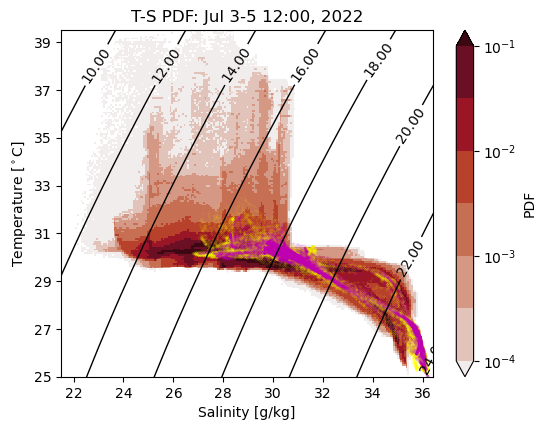

In [24]:
fig, ax = plt.subplots(1, figsize = (6,4.5))
m = np.log10(tshist.T).plot(cmap = cmo.amp, vmin = -4, vmax = -1, levels = 7, add_colorbar = False)
# plt.contour(saltstack[::10],tempstack[::10],denstack[::10], levels = 10, colors = 'k', vmin = 0, vmax = 3, lw = 1)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = plt.contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'Temperature [$^\circ$C]')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax, label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))


plt.scatter(S,T,s=0.05, c = 'yellow', alpha = 0.25)
plt.scatter(S1,T1,s=0.05, c = 'm', alpha = 0.25)
plt.title('T-S PDF: Jul 3-5 12:00, 2022')
# plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

# Separate them into two subplots 

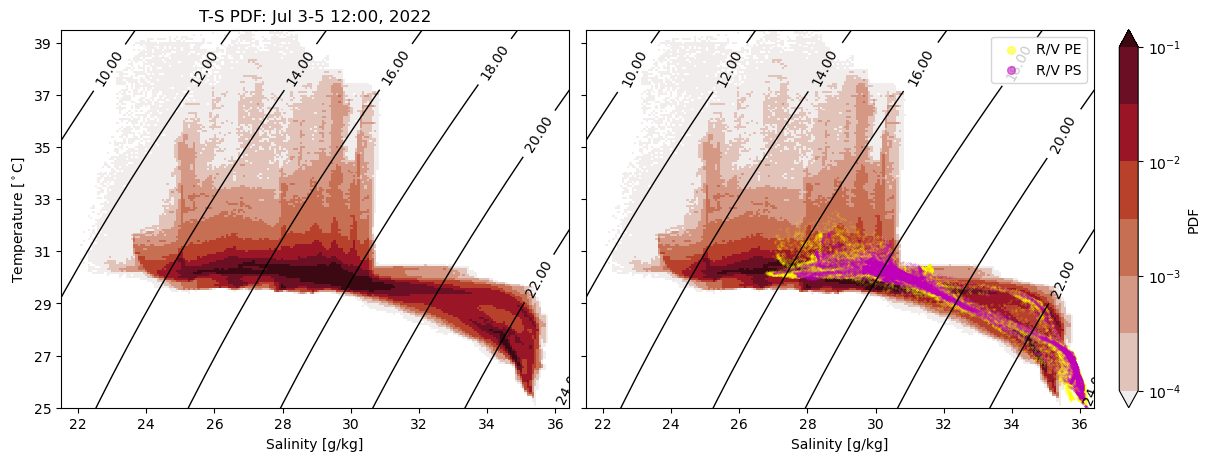

In [25]:
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(tshist.T).plot(ax=ax[0],cmap = cmo.amp, vmin = -4, vmax = -1, levels = 7, add_colorbar = False)
m = np.log10(tshist.T).plot(ax=ax[1],cmap = cmo.amp, vmin = -4, vmax = -1, levels = 7, add_colorbar = False)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax[1], label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

plt.scatter(S,T,s=0.05, c = 'yellow', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.05, c = 'm', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('T-S PDF: Jul 3-5 12:00, 2022')
plt.legend(markerscale=25)
# plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

# Change the colorscale and remove the first m of the water column to get rid of the temperature stratification

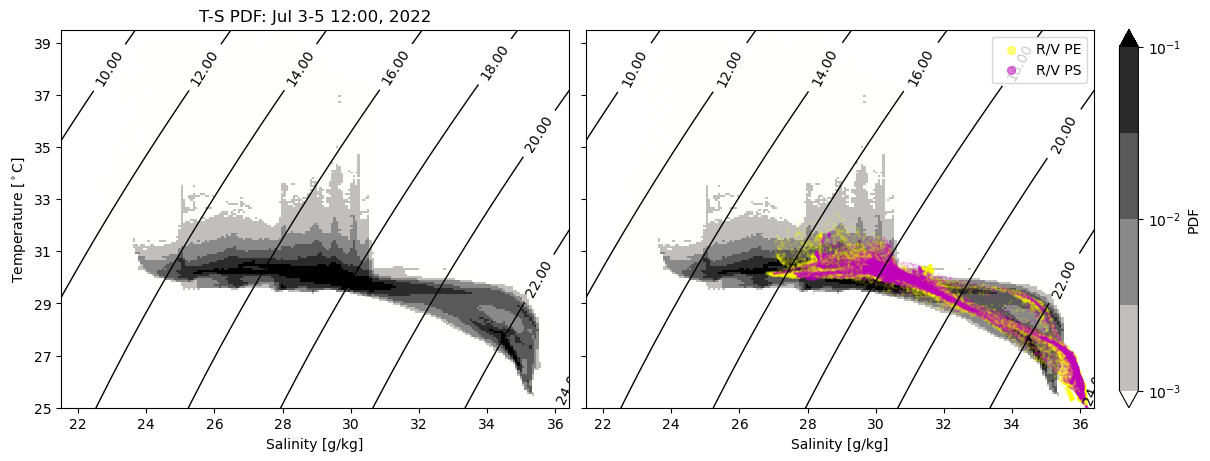

In [26]:
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(tshist.T).plot(ax=ax[0],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
m = np.log10(tshist.T).plot(ax=ax[1],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax[1], label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

plt.scatter(S,T,s=0.05, c = 'yellow', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.05, c = 'm', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('T-S PDF: Jul 3-5 12:00, 2022')
plt.legend(markerscale=25)
# plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

In [27]:
z = ds.z_rho.where(box).sel(ocean_time=tslice).load()

temp = ds.temp.where(box).sel(ocean_time=tslice).load()
temp1 = temp.where(z<-1).sel(ocean_time=tslice).load()
salt = ds.salt.where(box).sel(ocean_time=tslice).load()
salt1 = salt.where(z<-1).sel(ocean_time=tslice).load()

print(temp1.max().values)
print(temp1.min().values)
print(salt1.max().values)
print(salt1.min().values)

37.92897033691406
25.12924575805664
35.773902893066406
22.288000106811523


In [38]:
tempbins = np.linspace(25,38,201)
saltbins = np.linspace(22,36,201)

# tshist1 = histogram(salt1,temp1,bins=[saltbins,tempbins],dim=['xi_rho','eta_rho','ocean_time','s_rho'],block_size=salt.ocean_time.size, density=True).compute()
S.name='salt'
T.name='temp'
tshist1 = histogram(S,T,bins=[saltbins,tempbins],dim=['xi_rho','eta_rho','ocean_time','s_rho'],block_size=salt.ocean_time.size, density=True).compute()

AttributeError: 'numpy.ndarray' object has no attribute 'name'

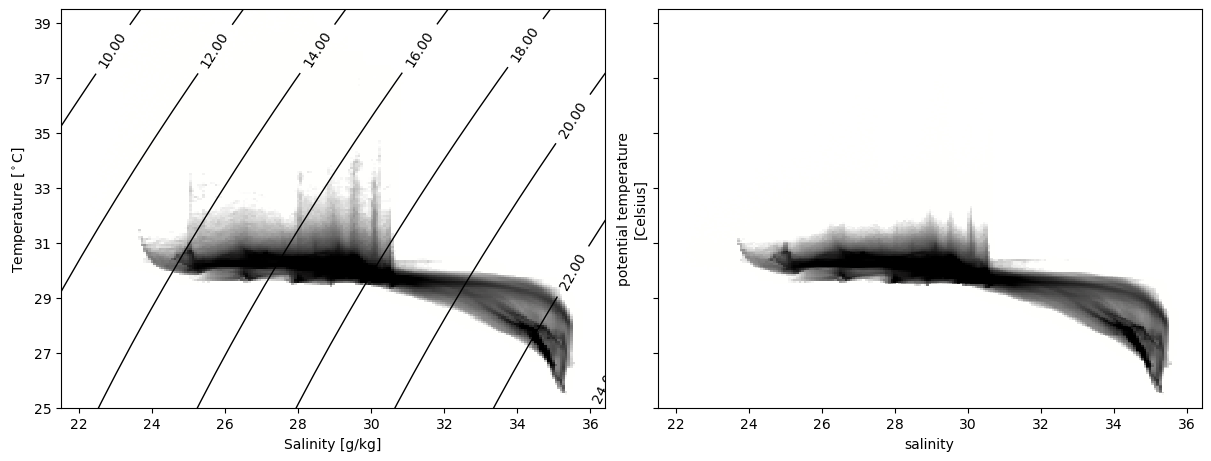

In [36]:
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(tshist.T).plot(ax=ax[0],cmap = cmo.gray_r, vmin = -3, vmax = -1,add_colorbar = False)
m = np.log10(tshist1.T).plot(ax=ax[1],cmap = cmo.gray_r, vmin = -3, vmax = -1,add_colorbar = False)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33, 35, 37, 39])

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


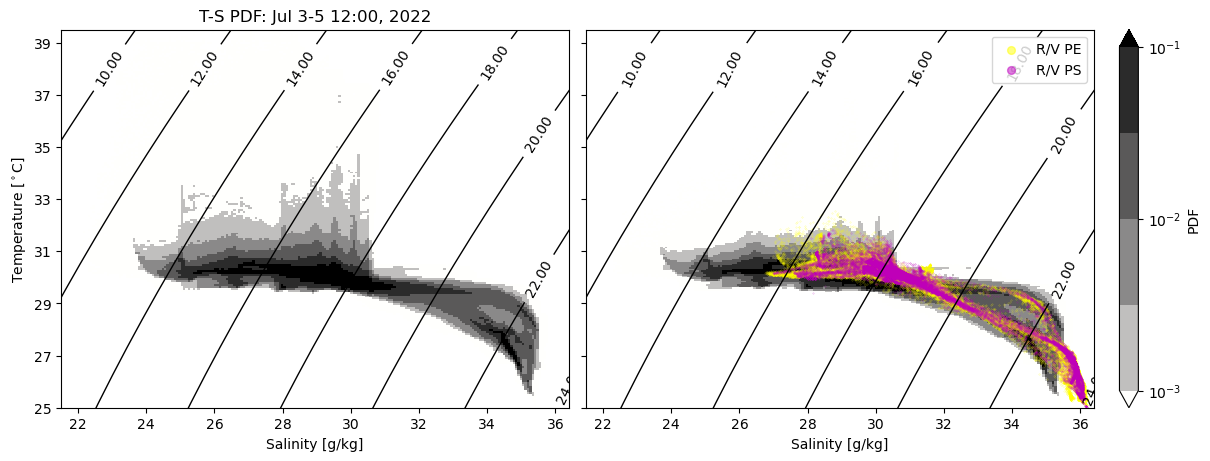

In [29]:
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True)

m = np.log10(tshist.T).plot(ax=ax[0],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
m = np.log10(tshist1.T).plot(ax=ax[1],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
plt.xlim(21.5,36.4)
plt.ylim(25,39.5)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33, 35, 37, 39])

cbar = fig.colorbar(m, ax = ax[1], label = r'PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f') # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33, 35, 37, 39])

plt.scatter(S,T,s=0.05, c = 'yellow', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.05, c = 'm', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('T-S PDF: Jul 3-5 12:00, 2022')
plt.legend(markerscale=25)
# plt.savefig('ts_diagram_cruise.jpg',dpi = 300)

In [53]:
S2 = S[~np.isnan(S)]
T2 = T[~np.isnan(T)]

(43770,)

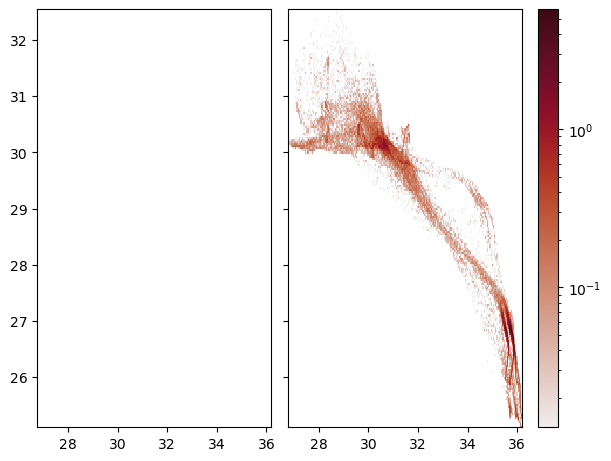

In [63]:
import matplotlib as mpl

fig, ax = plt.subplots(1,2, figsize = (6,4.5), constrained_layout=True, sharex=True,sharey=True)

test = plt.hist2d(S2,T2, bins = 200,density=True,norm=mpl.colors.LogNorm(), cmap = cmo.amp)
fig.colorbar(test[3])

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/tmp/ipykernel_878/2591636225.py:19: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)


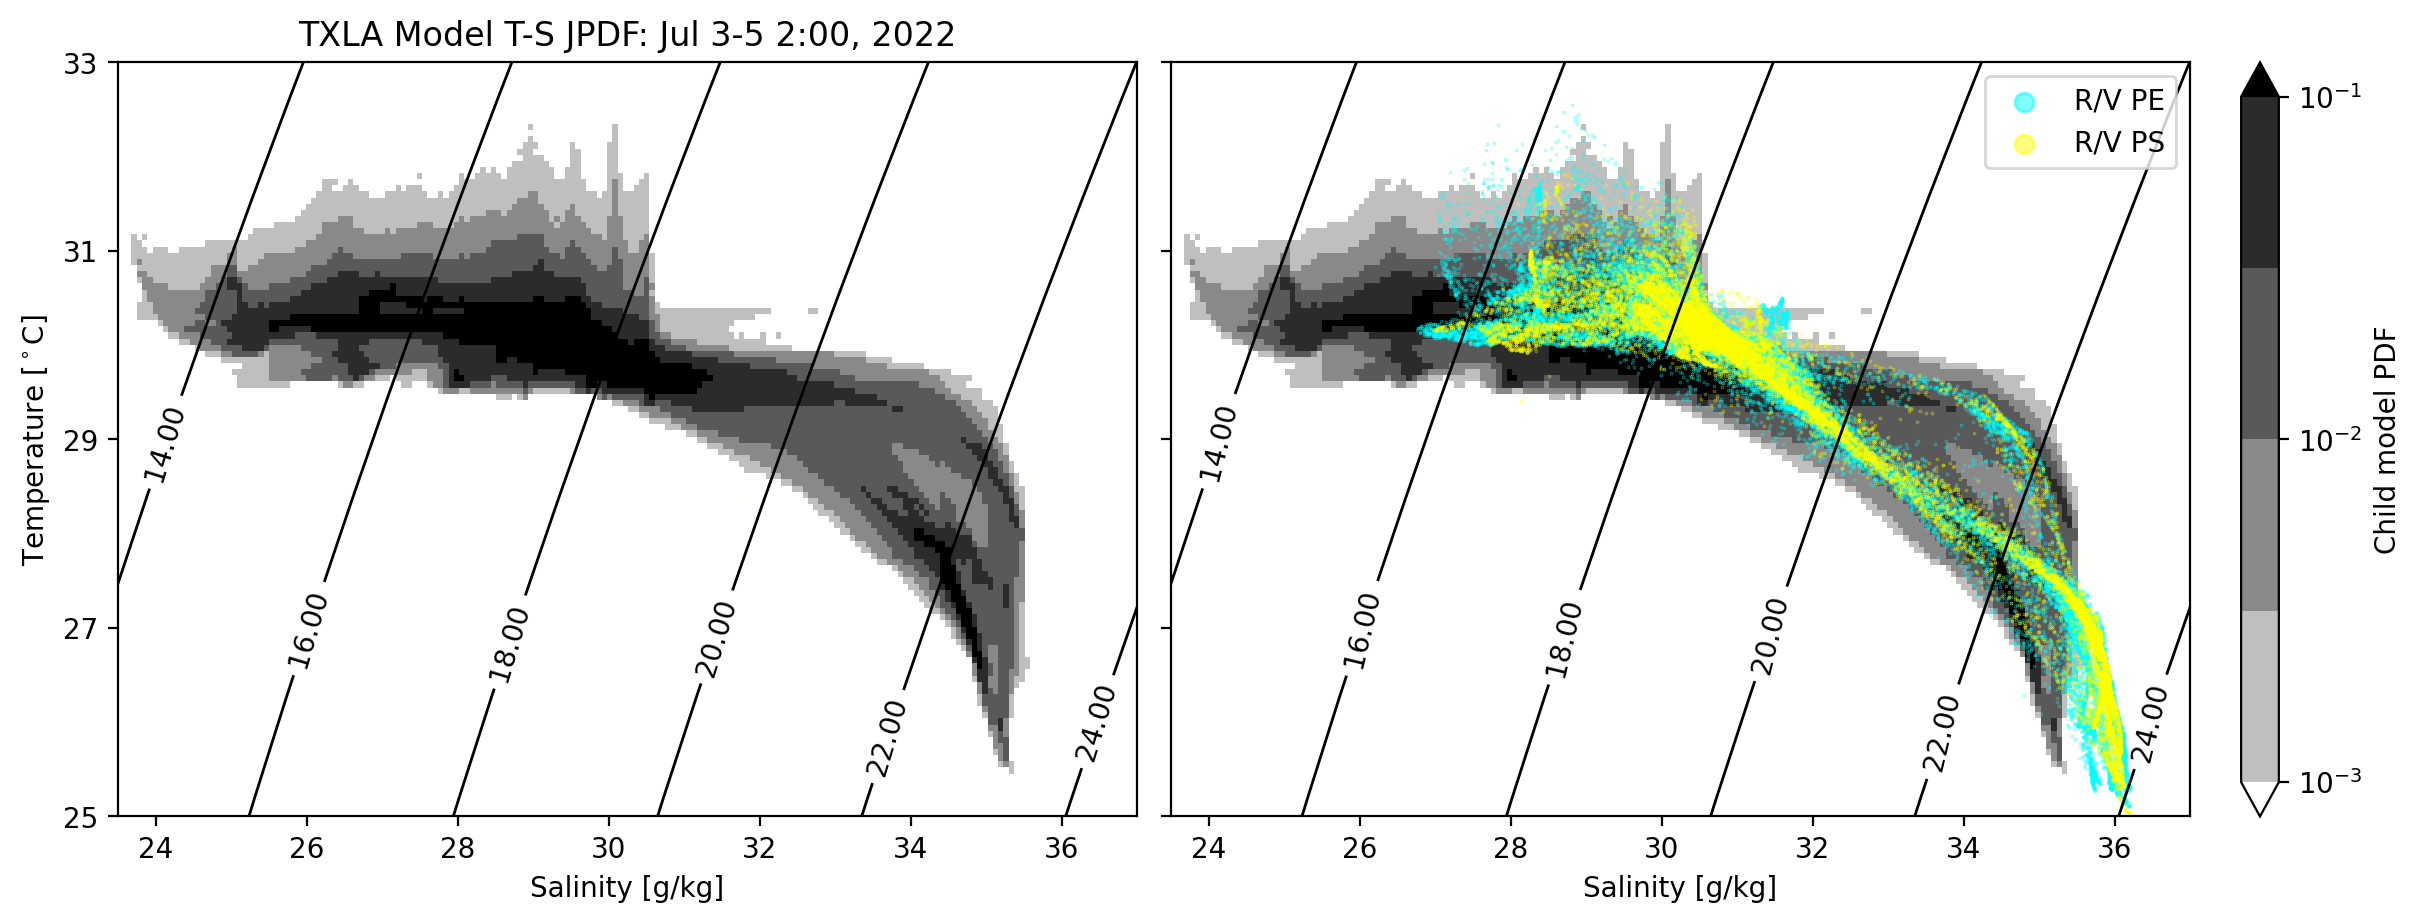

In [121]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True,dpi=200)

m = np.log10(tshist1.T).plot(ax=ax[0],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
m = np.log10(tshist1.T).plot(ax=ax[1],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
plt.xlim(23.5,37)
plt.ylim(25,33)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33])

cbar = fig.colorbar(m, ax = ax[1], label = r'Child model PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33])

plt.scatter(S,T,s=0.075, c = 'cyan', alpha = 0.5, label = r'R/V PE')
plt.scatter(S1,T1,s=0.075, c = 'yellow', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('TXLA Model T-S JPDF: Jul 3-5 2:00, 2022')
plt.legend(markerscale=25)
plt.savefig('ts_diagram_cruise_SA.jpg',dpi = 300)

In [104]:
S = data['vmp_bin']['SA'][:,9685:11500]
T = data['vmp_bin']['theta'][:,9685:11500]
print(np.shape(S),np.shape(T))

(60, 1815) (60, 1815)


In [109]:
S11 = data['vmp_bin']['SP'][:,9685:11500]
T11 = data['vmp_bin']['theta'][:,9685:11500]
print(np.shape(S11),np.shape(T11))

S22 = data['vmp_binSP']['SP'][:,5909:7020]
T22 = data['vmp_binSP']['theta'][:,5909:7020]
print(np.shape(S22),np.shape(T22))

(60, 1815) (60, 1815)
(60, 1111) (60, 1111)


/tmp/ipykernel_878/2533122532.py:19: UserWarning: The following kwargs were not used by contour: 'manual'
  CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)


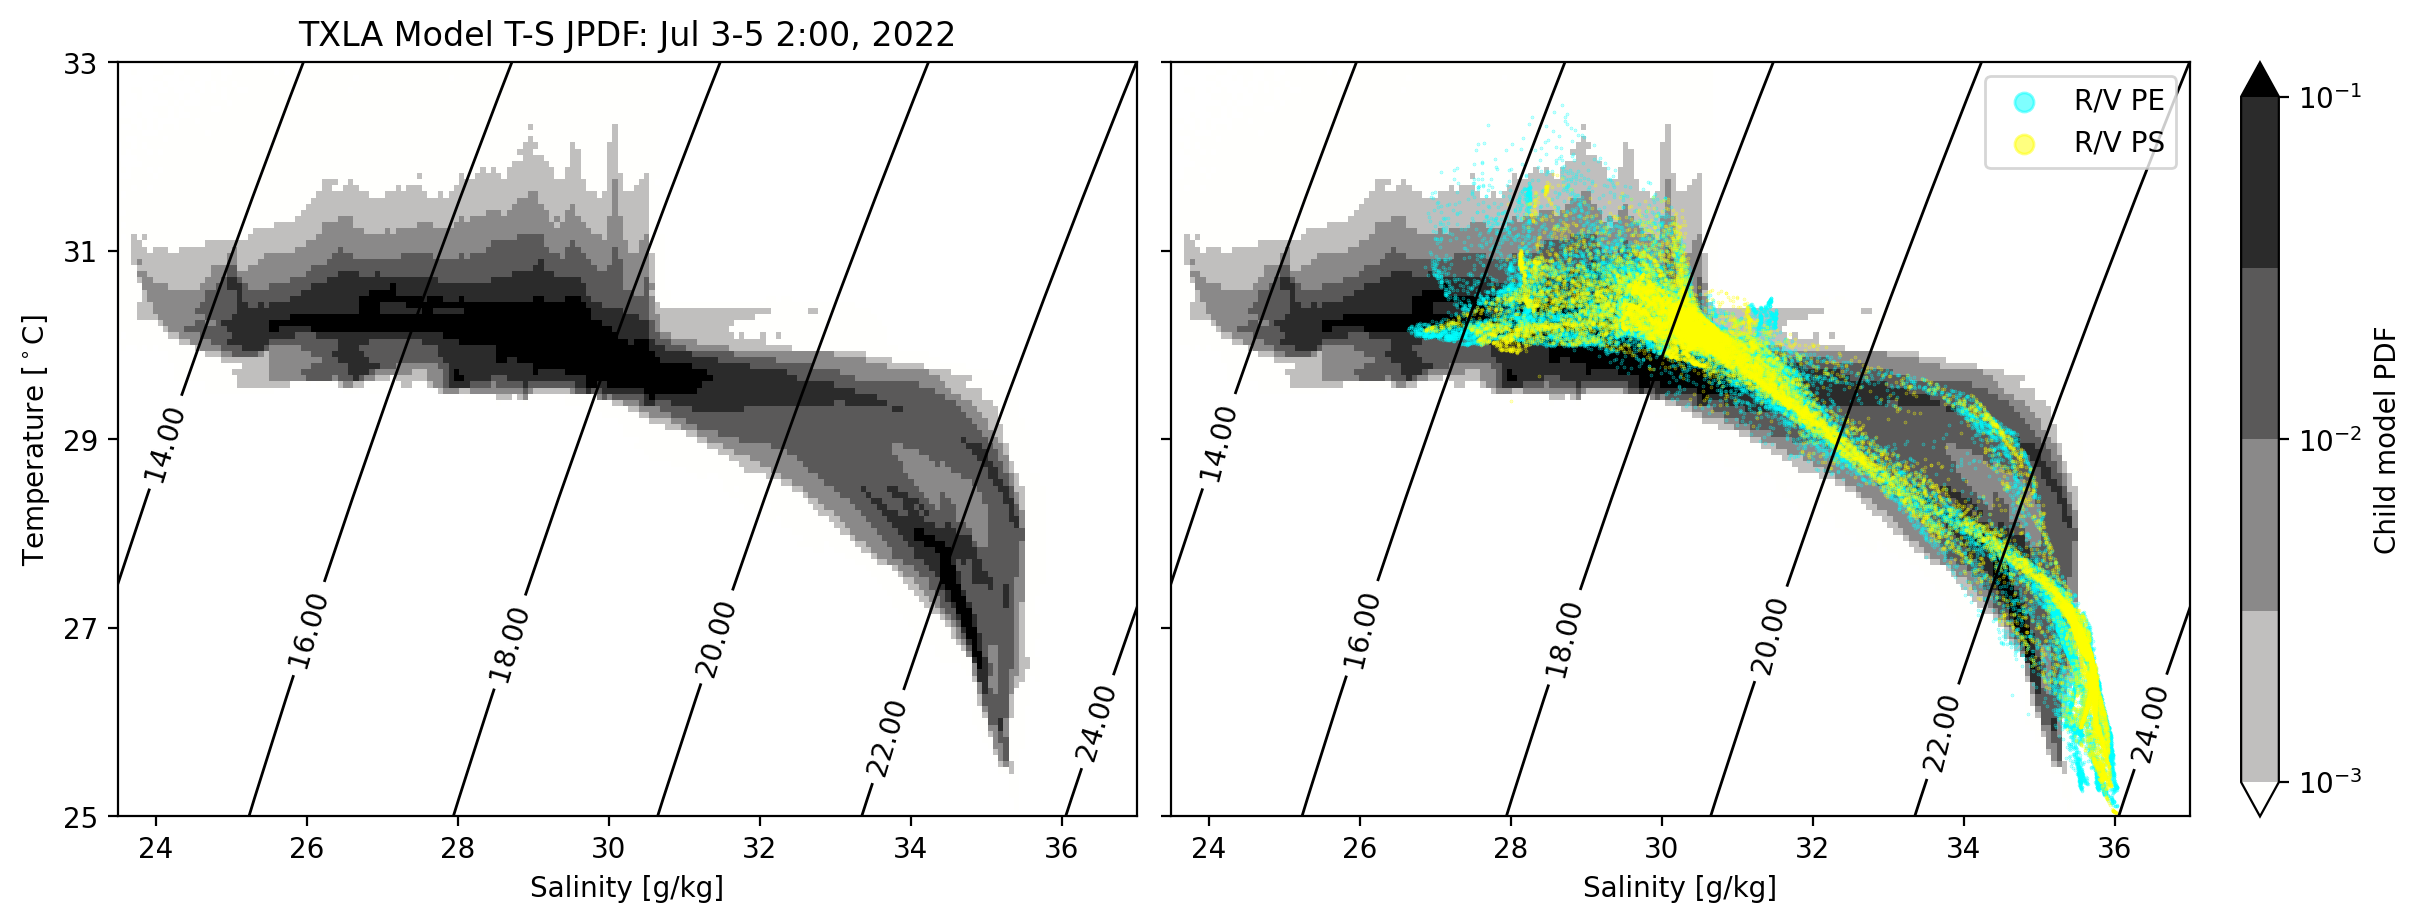

In [122]:
plt.ion()
fig, ax = plt.subplots(1,2, figsize = (12,4.5), constrained_layout=True, sharex=True,sharey=True,dpi=200)

m = np.log10(tshist1.T).plot(ax=ax[0],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
m = np.log10(tshist1.T).plot(ax=ax[1],cmap = cmo.gray_r, vmin = -3, vmax = -1, levels = 5,add_colorbar = False)
plt.xlim(23.5,37)
plt.ylim(25,33)

CS = ax[0].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1)

plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
# plt.show()
ax[0].set_ylabel(r'Temperature [$^\circ$C]')
ax[0].set_xlabel('Salinity [g/kg]')
ax[0].set_yticks([25,27,29, 31, 33])

cbar = fig.colorbar(m, ax = ax[1], label = r'Child model PDF', ticks = np.linspace(-4,0,5), format=tick.FormatStrFormatter('$10^{%d}$'))

CS = ax[1].contour(si,ti,dens, linestyles='solid', colors='k', levels = 10, linewidths=1,manual=True)
plt.clabel(CS, fontsize=10, inline=1, fmt='%.2f',manual=[(24,29),(26,27),(28,27),(31,27,),(33,26),(36.5,26)]) # Label every second level
plt.ylabel(r'')
plt.xlabel('Salinity [g/kg]')
plt.yticks([25,27,29, 31, 33])

plt.scatter(S11,T11,s=0.075, c = 'cyan', alpha = 0.5, label = r'R/V PE')
plt.scatter(S22,T22,s=0.075, c = 'yellow', alpha = 0.5, label = r'R/V PS')
ax[0].set_title('TXLA Model T-S JPDF: Jul 3-5 2:00, 2022')
plt.legend(markerscale=25)
plt.savefig('ts_diagram_cruise_sp.jpg',dpi = 300)

To conclude, there are at least two mixing pathways present in the TS diagram. The model broadly captures the observations very well. No point in doing a skill assement because even if the model got the right answer, it would be random error given the stochastic nature of the model fronts. 